In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def error_analysis(model, test_loader, classes, DEVICE=DEVICE):
    y_pred =[]
    y_true = []
    for i,data in enumerate(test_loader):
        x, y = data
        y = np.array(y.cpu())
        y_true.append(y)

        x = x.to(DEVICE)
        y_hat = model(x)
        pred = y_hat.max(1, keepdim=True)[1]
        pred = np.array(pred.cpu())
        y_pred.append(pred)
    
    y_pred_list = []
    y_true_list = []
    for i in range(len(y_pred)):
        y_pred_list += list(y_pred[i].ravel())
    for i in range(len(y_true)):
        y_true_list += list(y_true[i].ravel())
        
    plot_confusion_matrix(y_true_list, y_pred_list, classes=classes)


In [5]:
classes = np.array(['0', '1', '2', '3', '4', '5', '6', '7'])



In [14]:
densenet121_path = '/data/AlgProj/tct_yaoms/model/densenet-121_include_ascus_0722.pth'
resnet34_path =  '/data/AlgProj/tct_yaoms/model/resnet-34_include_ascus_0722.pth'
resnet50_path = '/data/AlgProj/tct_yaoms/model/resnet-50_include_ascus_0722.pth'

In [15]:
densenet121 = torch.load(densenet121_path)
resnet34 = torch.load(resnet34_path)
resnet50 = torch.load(resnet50_path)

In [9]:
import pandas as pd
# train_test_dict = train_test_split(csv, 0.2)
train_csv_path = '/data/AlgProj/tct_yaoms/data/tct_0513/train_df.csv'
test_csv_path = '/data/AlgProj/tct_yaoms/data/tct_0513/test_df.csv'
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)
train_test_dict = {'train':train_csv, 'test': test_csv}
len(train_test_dict['test'])

1018

In [11]:
import sys
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader, TensorDataset, Dataset

#hyperparameters 

IMG_SIZE = 224
BATCH_SIZE = 64
CLASSES = 8
EPOCH = 200

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 0.001

train_transformer = transforms.Compose([transforms.Resize((256,256)),
                                 transforms.RandomRotation((-180, 180)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomResizedCrop((224,224)),  
                                 transforms.ToTensor(),
                                       transforms.Normalize(IMG_MEAN,IMG_STD)]
                                )
test_transformer = transforms.Compose([transforms.Resize((256,256)),
                                  transforms.CenterCrop((224,224)),
                                 transforms.ToTensor(),
                                      transforms.Normalize(IMG_MEAN,IMG_STD)])
train_test_transformer = {'train':train_transformer, 'test':test_transformer}


class TCT_Dataset(Dataset):
    def __init__(self, phase, transforms=True):
        self.phase = phase
        self.transforms = transforms
        if phase == 'train':
            self.df = train_test_dict['train']
        else:
            self.df = train_test_dict['test']
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_path = self.df.loc[idx, 'img_path']
        img = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        
        if self.transforms:
            if self.phase == 'train':
                transformer = train_test_transformer['train']
            else:
                transformer = train_test_transformer['test']

            img = transformer(img)
        
        return (img, label)

In [12]:
train_dataset = TCT_Dataset('train')
test_dataset = TCT_Dataset('test')

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Confusion matrix, without normalization
[[143  51   2  15   6   5   4   0]
 [ 34 154  10  17   1   9   2   1]
 [  9  15  30   3  12   2   4   2]
 [ 23  62   3  55   2   5   3   0]
 [  3   5  10   0  56   2   3   3]
 [  1   7   3   0   6  67   3   1]
 [  2   0   0   0   4   3  93   0]
 [  0   0   0   0   0   0   0  62]]
Confusion matrix, without normalization
[[145  50   9   8   5   5   4   0]
 [ 22 169   5  16   2   6   5   3]
 [  8  16  30   3  10   1   9   0]
 [ 17  73   2  49   0   5   4   3]
 [  3   9  11   1  49   2   5   2]
 [  4   8   2   1   9  61   3   0]
 [  3   0   3   0   3   0  92   1]
 [  0   0   0   0   0   0   0  62]]
Confusion matrix, without normalization
[[146  47   6  12   4   7   3   1]
 [ 23 169   6  21   0   7   1   1]
 [  5  25  15   7  15   2   8   0]
 [ 17  75   1  50   2   5   1   2]
 [  1   7   7   1  53   4   6   3]
 [  0   2   2   0   5  74   4   1]
 [  2   2   3   0   7   0  88   0]
 [  0   0   0   0   1   0   0  61]]


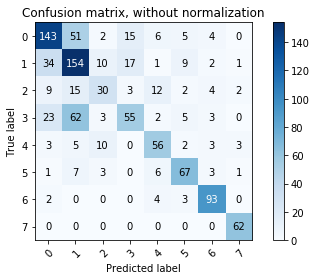

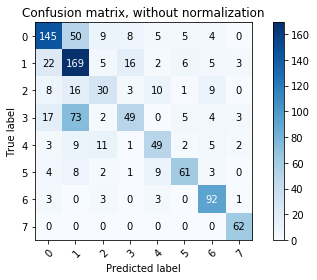

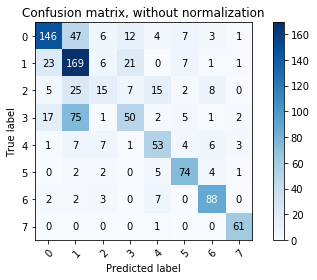

In [16]:
models = [densenet121, resnet34, resnet50]
for model in models:
     error_analysis(model, test_loader, classes, DEVICE=DEVICE)